# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Pau Argelaguet Franquelo"
student2 = "Natalie Bolon Brun"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(284216 + 285155)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/train_32x32.mat')
data_test = scipy.io.loadmat('data/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

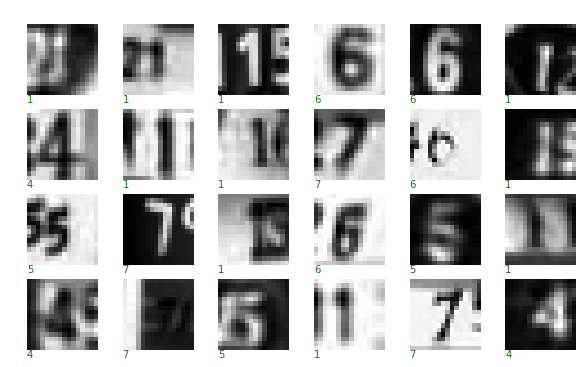

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [9]:
ex1_model = Sequential([
    Dense(5, input_shape=(256,), activation='softmax'),
])

ex1_model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
ex1_history = ex1_model.fit(x_train, y_train, epochs=300, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 39523 samples, validate on 14002 samples
Epoch 1/300
39523/39523 [==============================] - 1s 19us/step - loss: 1.5786 - acc: 0.3206 - val_loss: 1.5592 - val_acc: 0.3570
Epoch 2/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.5583 - acc: 0.3471 - val_loss: 1.5457 - val_acc: 0.3624
Epoch 3/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.5495 - acc: 0.3492 - val_loss: 1.5388 - val_acc: 0.3642
Epoch 4/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5437 - acc: 0.3503 - val_loss: 1.5337 - val_acc: 0.3654
Epoch 5/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.5393 - acc: 0.3508 - val_loss: 1.5307 - val_acc: 0.3654
Epoch 6/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.5361 - acc: 0.3520 - val_loss: 1.5277 - val_acc: 0.3669
Epoch 7/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.5336 - acc: 0.3523 - val_loss: 1.5258 - 

Epoch 118/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4891 - acc: 0.3950 - val_loss: 1.5155 - val_acc: 0.4170
Epoch 119/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4890 - acc: 0.3950 - val_loss: 1.5154 - val_acc: 0.4138
Epoch 120/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4888 - acc: 0.3961 - val_loss: 1.5154 - val_acc: 0.4147
Epoch 121/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4888 - acc: 0.3953 - val_loss: 1.5152 - val_acc: 0.4124
Epoch 122/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4886 - acc: 0.3961 - val_loss: 1.5159 - val_acc: 0.4112
Epoch 123/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4886 - acc: 0.3961 - val_loss: 1.5153 - val_acc: 0.4133
Epoch 124/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4884 - acc: 0.3965 - val_loss: 1.5151 - val_acc: 0.4106
Epoch 125/300
39523/

39523/39523 [==============================] - 0s 12us/step - loss: 1.4815 - acc: 0.4045 - val_loss: 1.5198 - val_acc: 0.4169
Epoch 235/300
39523/39523 [==============================] - 1s 18us/step - loss: 1.4815 - acc: 0.4049 - val_loss: 1.5194 - val_acc: 0.4149
Epoch 236/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4815 - acc: 0.4045 - val_loss: 1.5192 - val_acc: 0.4140
Epoch 237/300
39523/39523 [==============================] - 0s 12us/step - loss: 1.4815 - acc: 0.4042 - val_loss: 1.5195 - val_acc: 0.4171
Epoch 238/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4815 - acc: 0.4046 - val_loss: 1.5201 - val_acc: 0.4175
Epoch 239/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4814 - acc: 0.4049 - val_loss: 1.5197 - val_acc: 0.4171
Epoch 240/300
39523/39523 [==============================] - 0s 11us/step - loss: 1.4813 - acc: 0.4051 - val_loss: 1.5199 - val_acc: 0.4171
Epoch 241/300
39523/39523 [=======

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


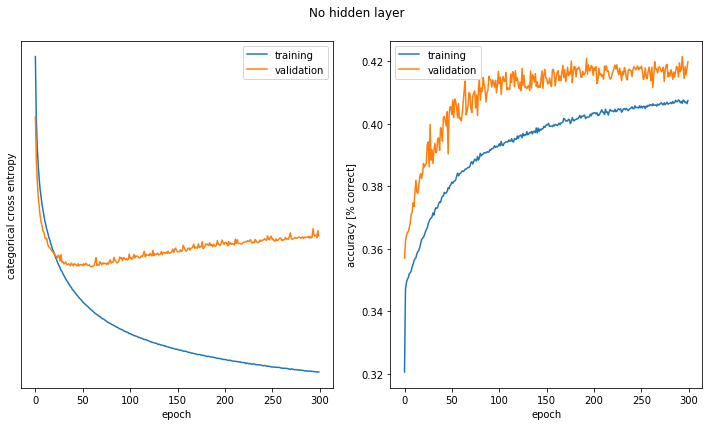

In [10]:
ex1_model.summary()
plot_history(ex1_history, "No hidden layer")
plt.show()

In [11]:
score = ex1_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.52143010942
Test accuracy: 0.419868590202


In [12]:
yhat_test = ex1_model.predict_on_batch(x_test)
error = np.linalg.norm(((yhat_test.round()) - y_test),axis=1)
error_indices = np.nonzero(error)[0]

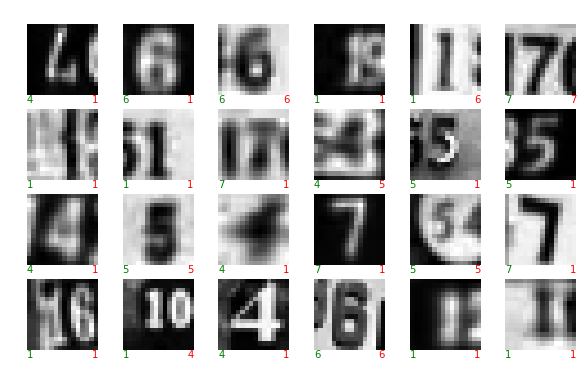

In [13]:
plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)
plt.show()

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [14]:
ex2_model_sgd = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [15]:
lrates = [0.01, 0.05, 0.1, 0.5, 1, 2]
histories = []
for lrate in lrates:
    ex2_model_sgd.compile(optimizer=SGD(lr=lrate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    histories.append(
        ex2_model_sgd.fit(x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1))

Train on 39523 samples, validate on 14002 samples
Epoch 1/50
39523/39523 [==============================] - 1s 18us/step - loss: 1.5535 - acc: 0.3412 - val_loss: 1.5291 - val_acc: 0.3642
Epoch 2/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.5304 - acc: 0.3513 - val_loss: 1.5126 - val_acc: 0.3663
Epoch 3/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.5167 - acc: 0.3518 - val_loss: 1.4978 - val_acc: 0.3722
Epoch 4/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.5039 - acc: 0.3543 - val_loss: 1.4819 - val_acc: 0.3741
Epoch 5/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.4912 - acc: 0.3563 - val_loss: 1.4676 - val_acc: 0.3858
Epoch 6/50
39523/39523 [==============================] - 1s 21us/step - loss: 1.4769 - acc: 0.3611 - val_loss: 1.4487 - val_acc: 0.3803
Epoch 7/50
39523/39523 [==============================] - 1s 16us/step - loss: 1.4615 - acc: 0.3665 - val_loss: 1.4315 - val_acc

39523/39523 [==============================] - 1s 15us/step - loss: 0.3918 - acc: 0.8835 - val_loss: 0.5249 - val_acc: 0.8534
Epoch 19/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.3870 - acc: 0.8837 - val_loss: 0.5229 - val_acc: 0.8519
Epoch 20/50
39523/39523 [==============================] - 1s 15us/step - loss: 0.3847 - acc: 0.8856 - val_loss: 0.5012 - val_acc: 0.8601
Epoch 21/50
39523/39523 [==============================] - 1s 15us/step - loss: 0.3806 - acc: 0.8856 - val_loss: 0.5042 - val_acc: 0.8615
Epoch 22/50
39523/39523 [==============================] - 1s 15us/step - loss: 0.3825 - acc: 0.8849 - val_loss: 0.5229 - val_acc: 0.8516
Epoch 23/50
39523/39523 [==============================] - 1s 15us/step - loss: 0.3770 - acc: 0.8873 - val_loss: 0.4952 - val_acc: 0.8642
Epoch 24/50
39523/39523 [==============================] - 1s 25us/step - loss: 0.3745 - acc: 0.8875 - val_loss: 0.5440 - val_acc: 0.8515
Epoch 25/50
39523/39523 [=====================

39523/39523 [==============================] - 1s 15us/step - loss: 0.3860 - acc: 0.8785 - val_loss: 0.8440 - val_acc: 0.7833
Epoch 37/50
39523/39523 [==============================] - 1s 15us/step - loss: 0.3770 - acc: 0.8825 - val_loss: 0.7761 - val_acc: 0.7899
Epoch 38/50
39523/39523 [==============================] - 1s 15us/step - loss: 0.3783 - acc: 0.8807 - val_loss: 0.6112 - val_acc: 0.8455
Epoch 39/50
39523/39523 [==============================] - 1s 15us/step - loss: 0.3796 - acc: 0.8804 - val_loss: 0.6093 - val_acc: 0.8417
Epoch 40/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3746 - acc: 0.8809 - val_loss: 0.5700 - val_acc: 0.8555
Epoch 41/50
39523/39523 [==============================] - 1s 15us/step - loss: 0.3712 - acc: 0.8840 - val_loss: 0.6235 - val_acc: 0.8433
Epoch 42/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.3683 - acc: 0.8860 - val_loss: 0.5839 - val_acc: 0.8540
Epoch 43/50
39523/39523 [=====================

In [16]:
print("LR loss acc val_loss val_acc")
for lr, h in zip(lrates, histories):
    print(lr, h.history.get('loss')[-1], h.history.get('acc')[-1], 
          h.history.get('val_loss')[-1], h.history.get('val_acc')[-1])

LR loss acc val_loss val_acc
0.01 0.775249863051 0.762695139521 0.818966469379 0.739608627424
0.05 0.444581884422 0.867343066101 0.589894622075 0.82423939433
0.1 0.32295693116 0.903322116304 0.51889807128 0.865519211567
0.5 0.343205634096 0.895200263078 0.656760405411 0.834380802759
1 0.354472626292 0.888141082378 0.577853251586 0.858734466607
2 0.804948852423 0.798522379428 0.794029626859 0.785459220137


**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is too large, the solucion may oscillate around a value and never achieve a minimum. It may even lead to increasing error during the training period obtening very poor results.

B) If the learning rate is too small, the improvement per epoch may be too small too and so, the number of epochs needed to achieve a reasonable results may be extremly large. 

In [17]:
ex2_model_ada = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_ada.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [18]:
ex2_model_ada.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

adam_history = ex2_model_ada.fit(
    x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 39523 samples, validate on 14002 samples
Epoch 1/50
39523/39523 [==============================] - 1s 20us/step - loss: 1.3801 - acc: 0.4364 - val_loss: 1.1190 - val_acc: 0.5973
Epoch 2/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.9766 - acc: 0.6753 - val_loss: 0.8674 - val_acc: 0.7303
Epoch 3/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.7977 - acc: 0.7533 - val_loss: 0.7963 - val_acc: 0.7532
Epoch 4/50
39523/39523 [==============================] - 1s 17us/step - loss: 0.7157 - acc: 0.7816 - val_loss: 0.7436 - val_acc: 0.7688
Epoch 5/50
39523/39523 [==============================] - 2s 42us/step - loss: 0.6670 - acc: 0.7963 - val_loss: 0.7146 - val_acc: 0.7823
Epoch 6/50
39523/39523 [==============================] - 1s 16us/step - loss: 0.6338 - acc: 0.8076 - val_loss: 0.6960 - val_acc: 0.7871
Epoch 7/50
39523/39523 [==============================] - 1s 30us/step - loss: 0.6048 - acc: 0.8172 - val_loss: 0.6825 - val_acc

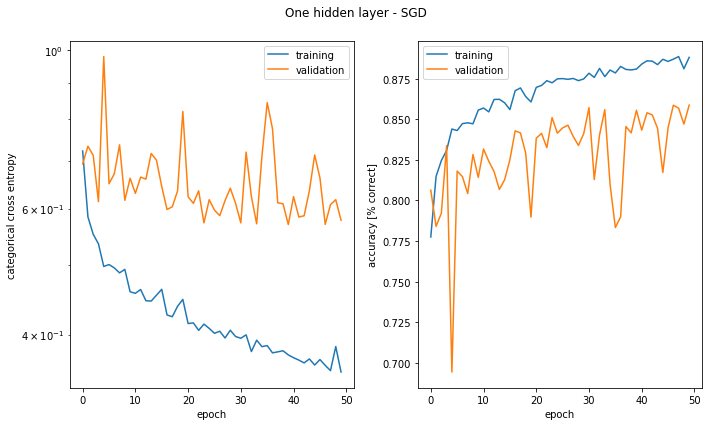

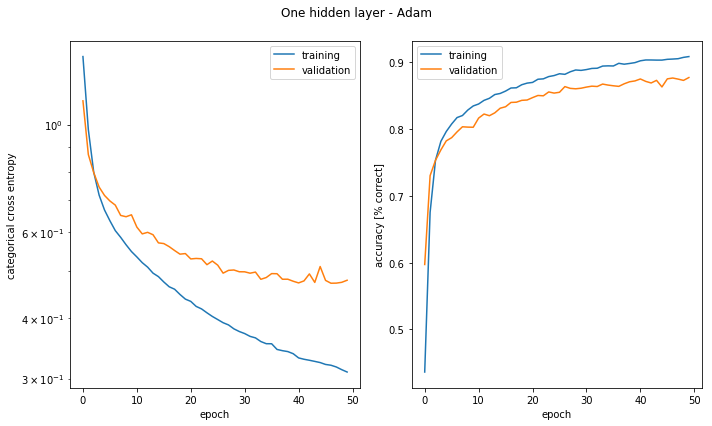

In [19]:
# histories[2] (lr=0.1) gives the best results
plot_history(histories[4], "One hidden layer - SGD")
plot_history(adam_history, "One hidden layer - Adam")
plt.show()

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [ ]:
ex3_model = Sequential([
    Dense(64, input_shape=(256,), activation="relu"),
    Dense(5, activation="softmax"),
])

ex3_model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ex3_history = ex3_model.fit(
    x_train, y_train, epochs=500, validation_data=(x_test,y_test), batch_size=128, verbose=1)

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 1s 21us/step - loss: 1.4187 - acc: 0.4032 - val_loss: 1.1717 - val_acc: 0.5932
Epoch 2/500
39523/39523 [==============================] - 1s 16us/step - loss: 1.0168 - acc: 0.6571 - val_loss: 0.9144 - val_acc: 0.7243
Epoch 3/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.8190 - acc: 0.7461 - val_loss: 0.8080 - val_acc: 0.7522
Epoch 4/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.7287 - acc: 0.7785 - val_loss: 0.7605 - val_acc: 0.7597
Epoch 5/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.6810 - acc: 0.7932 - val_loss: 0.7328 - val_acc: 0.7787
Epoch 6/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.6411 - acc: 0.8047 - val_loss: 0.6947 - val_acc: 0.7892
Epoch 7/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.6120 - acc: 0.8156 - val_loss: 0.6840 - 

Epoch 118/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.2325 - acc: 0.9276 - val_loss: 0.5064 - val_acc: 0.8842
Epoch 119/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.2370 - acc: 0.9268 - val_loss: 0.5026 - val_acc: 0.8849
Epoch 120/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.2363 - acc: 0.9275 - val_loss: 0.5077 - val_acc: 0.8829
Epoch 121/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.2349 - acc: 0.9274 - val_loss: 0.5063 - val_acc: 0.8816
Epoch 122/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.2317 - acc: 0.9277 - val_loss: 0.5109 - val_acc: 0.8836
Epoch 123/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.2345 - acc: 0.9274 - val_loss: 0.5138 - val_acc: 0.8819
Epoch 124/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.2317 - acc: 0.9291 - val_loss: 0.5349 - val_acc: 0.8748
Epoch 125/500
39523/

39523/39523 [==============================] - 2s 55us/step - loss: 0.1806 - acc: 0.9427 - val_loss: 0.5738 - val_acc: 0.8824
Epoch 235/500
39523/39523 [==============================] - 1s 31us/step - loss: 0.1830 - acc: 0.9424 - val_loss: 0.5782 - val_acc: 0.8800
Epoch 236/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.1814 - acc: 0.9435 - val_loss: 0.5593 - val_acc: 0.8867
Epoch 237/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1795 - acc: 0.9446 - val_loss: 0.5612 - val_acc: 0.8834
Epoch 238/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.1819 - acc: 0.9427 - val_loss: 0.5759 - val_acc: 0.8826
Epoch 239/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1811 - acc: 0.9427 - val_loss: 0.5726 - val_acc: 0.8822
Epoch 240/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1803 - acc: 0.9440 - val_loss: 0.5612 - val_acc: 0.8859
Epoch 241/500
39523/39523 [=======

In [ ]:
plot_history(ex3_history, "Adam overfitting")
plt.show()

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: It starts to overfit a bit before epoch 100, where we can see that the validation error goes up and accuracy goes down.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: For the loss curve, overfitting can be detected as a minimum after which the curve has a relevant positive slope. The difference between the validation set and the training set keep increasing as the traning loss goes to zero while the training loss keeps increasing. 
For the accuracy curve, after reaching overfitting, the accuracy of the validation set remains quite stable although it decreases at a low speed while the accuracy if the training set keeps increasing towards 100%.

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [ ]:
hidden_n = [10, 50, 100, 200, 300, 400, 500, 1000]

accuracy = {}
losses = {}

for n in hidden_n:
    print("Number of hidden units:", params)
    accuracy[params] = []
    losses[params] = []
    for n in range(5):
        print("Iteration number", n)
        model = Sequential([
            Dense(params, input_shape=(256,), activation='relu'),
            Dense(5, activation='softmax'),
        ])

        model.compile(optimizer=SGD(lr=0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        h = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=200,  batch_size=128, verbose=0)
        accuracy[params].append(h.history.get('val_acc')[-1]) 
        losses[params].append(h.history.get('val_loss')[-1])

In [ ]:
fig1, axes1 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=False)
fig2, axes2 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)
fs = 12
for n in range(len(hidden_n)):
    row = int(n/4)
    col = n%4
    data_loss = losses[hidden_n[n]]
    data_acc = accuracy[hidden_n[n]]
    
    axes1[row, col].boxplot(data_loss, manage_xticks=True)
    axes1[row, col].set_title('LOSS -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
    axes2[row, col].boxplot(data_acc, manage_xticks=True)
    axes2[row, col].set_title('ACCURACY -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
plt.show()

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [ ]:
models = []
nh_2 = 77
nh_3 = 66
nh_4 = 59

models.append(Sequential([
    Dense(100, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_2, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_2, activation='relu'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_3, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_3, activation='relu'),
    Dense(nh_3, activation='relu'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(5, activation='softmax')
]))

for model in models:
    model.summary()

In [ ]:
accuracy = {}
losses = {}
histories = {}

for i, model in enumerate(models):
    print("Model", i)
    accuracy[model] = []
    losses[model] = []
    histories[model] = []
    for n in range(5):
        print("Iteration number {}".format(n))
        model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
        
        h = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300,  batch_size=128, verbose=0)
        print('Test accuracy: {}'.format(h.history.get('val_acc')[-1]))
        accuracy[model].append(h.history.get('val_acc')[-1]) 
        print('Test loss: {}'.format(h.history.get('val_loss')[-1]))
        losses[model].append(h.history.get('val_loss')[-1])
        histories[model].append(h)

In [ ]:
fig1, axes1 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fig2, axes2 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fs = 12

for n in range(len(models)):
    row = 0
    col = n%4

    data_loss = losses[models[n]]
    data_acc = accuracy[models[n]]
    
    axes1[col].boxplot(data_loss, manage_xticks=True)
    axes1[col].set_title('LOSS -- Hidden layers:{}'.format(n), fontsize=fs)
    
    axes2[col].boxplot(data_acc, manage_xticks=True)
    axes2[col].set_title('ACCURACY -- Hidden layers:{}'.format(n), fontsize=fs)
    
plt.show()

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [ ]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform',
          kernel_regularizer=regularizers.l2(0.0005),
          bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h1 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h1.history.get('acc')[-1])
print("Val Accuracy", h1.history.get('val_acc')[-1])

In [ ]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h2 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h2.history.get('acc')[-1])
print("Val Accuracy", h2.history.get('val_acc')[-1])

In [ ]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h3 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h3.history.get('acc')[-1])
print("Val Accuracy", h3.history.get('val_acc')[-1])

In [ ]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform',
          kernel_regularizer=regularizers.l2(0.0005),
          bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h4 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h4.history.get('acc')[-1])
print("Val Accuracy", h4.history.get('val_acc')[-1])

In [ ]:
nh_4 = 59

model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h5 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h5.history.get('acc')[-1])
print("Val Accuracy", h5.history.get('val_acc')[-1])

In [ ]:
model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h6 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h6.history.get('acc')[-1])
print("Val Accuracy", h6.history.get('val_acc')[-1])

In [ ]:
model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu'),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h7 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h7.history.get('acc')[-1])
print("Val Accuracy", h7.history.get('val_acc')[-1])

In [ ]:
model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h8 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h8.history.get('acc')[-1])
print("Val Accuracy", h8.history.get('val_acc')[-1])

In [ ]:
plot_history(h1, "Regularization, batch normalization (1 layer)")
plt.show()

plot_history(h2, "Nothing (1 layer)")
plt.show()

plot_history(h3, "Batch normalization (1 layer)")
plt.show()

plot_history(h4, "Regularization, batch normalization, Dropout (1 layer)")
plt.show()

plot_history(h5, "Nothing (4 layers)")
plt.show()

plot_history(h6, "Regularization, batch normalization (4 layers)")
plt.show()

plot_history(h7, "Batch normalization (4 layers)")
plt.show()

plot_history(h8, "Regularization, batch normalization, Dropout (4 layers)")
plt.show()

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [13]:
x_train_cnn = x_train.reshape(-1,16,16,1)
x_test_cnn = x_test.reshape(-1,16,16,1)

print('x_train shape:', x_train_cnn.shape)
print('x_test shape:', x_test_cnn.shape)
print(x_train_cnn.shape[0], 'train samples')
print(x_test_cnn.shape[0], 'test samples')

input_shape = x_train_cnn.shape
num_classes = 5
batch_size = 128


ex7_model = Sequential()
ex7_model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(16,16,1)))
ex7_model.add(Conv2D(64, (3, 3), activation='relu'))
ex7_model.add(MaxPooling2D(pool_size=(2, 2)))
ex7_model.add(Conv2D(128, (3, 3), activation='relu'))

ex7_model.add(Dropout(0.5))
ex7_model.add(Flatten())
ex7_model.add(Dense(300, activation='relu'))
ex7_model.add(Dropout(0.5))
ex7_model.add(Dense(num_classes, activation='softmax'))

ex7_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = ex7_model.fit(x_train_cnn, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_data=(x_test_cnn, y_test))

score = ex7_model.evaluate(x_test_cnn, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (39523, 16, 16, 1)
x_test shape: (14002, 16, 16, 1)
39523 train samples
14002 test samples
Train on 39523 samples, validate on 14002 samples
Epoch 1/30
39523/39523 [==============================] - 63s 2ms/step - loss: 0.9771 - acc: 0.6230 - val_loss: 0.4051 - val_acc: 0.8671
Epoch 2/30
39523/39523 [==============================] - 58s 1ms/step - loss: 0.3664 - acc: 0.8808 - val_loss: 0.2722 - val_acc: 0.9134
Epoch 3/30
39523/39523 [==============================] - 57s 1ms/step - loss: 0.2842 - acc: 0.9080 - val_loss: 0.2649 - val_acc: 0.9182
Epoch 4/30
39523/39523 [==============================] - 68s 2ms/step - loss: 0.2540 - acc: 0.9188 - val_loss: 0.2398 - val_acc: 0.9254
Epoch 5/30
39523/39523 [==============================] - 61s 2ms/step - loss: 0.2314 - acc: 0.9262 - val_loss: 0.2197 - val_acc: 0.9324
Epoch 6/30
39523/39523 [==============================] - 60s 2ms/step - loss: 0.2157 - acc: 0.9304 - val_loss: 0.2304 - val_acc: 0.9327
Epoch 7/30
39523/39523

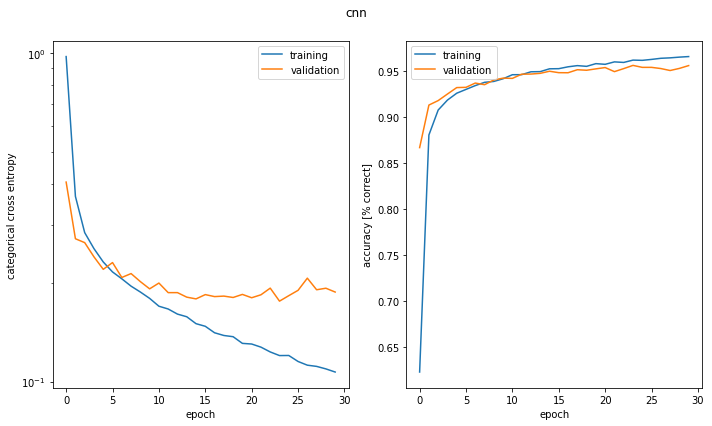

In [14]:
plot_history(history, "cnn")
plt.show()

In [15]:
ex7_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               614700    
__________